In [13]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.ndimage
import coordinate_transform_functions as ct
from _globals import *
from tqdm import tqdm

In [2]:
# import data
hdul = fits.open('data/cube_ext.fits')
data = hdul[0].data
# invert data axes
data = np.swapaxes(data, 0, 2)

In [3]:
CygOB2_pos = ct.radec_to_data(CygOB2_ra, CygOB2_dec, CygOB2_dist)
CygOB2_pos

(327.5277644973957, 457.475113269391, 42.691748237180896)

In [4]:
def line_of_sight(ra, dec, dist, gridstep_pc=10, sun_pos=(300.5, 300.5, 40.5)):
    """
    Create a list of 3D coordinates along a line of sight.
    
    Parameters
    ----------
    ra, dec : float
        Sky coordinates of target in decimal degrees.
    dist : float
        Distance to target in pc.
    gridstep_pc : float, optional
        Size of data gridstep in pc. The default is 10.
    sun_pos : tuple, optional
        Position of the Sun in data coordinates. The default is (300.5, 300.5, 40.5).
    """
    # Convert target sky coordinates to data coordinates
    x, y, z = ct.radec_to_data(ra, dec, dist)
    # Create a line between the Sun and the target
    npoints = int(dist / gridstep_pc)
    xarr = np.linspace(sun_pos[0], x, npoints)
    yarr = np.linspace(sun_pos[1], y, npoints)
    zarr = np.linspace(sun_pos[2], z, npoints)
    return xarr, yarr, zarr

Cubic interpolation:

In [5]:
# Extract the values along the line, using cubic interpolation
xarr, yarr, zarr = line_of_sight(CygOB2_ra, CygOB2_dec, CygOB2_dist)
diff_ext = scipy.ndimage.map_coordinates(data, np.vstack((xarr, yarr, zarr)))

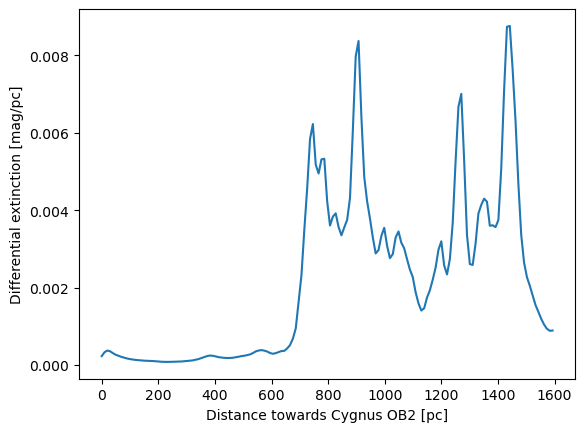

In [7]:
# array of distances along line to Cygnus OB2
dist_arr = np.linspace(0, CygOB2_dist, len(diff_ext))

fig, ax = plt.subplots()
ax.plot(dist_arr, diff_ext)
ax.set_xlabel('Distance towards Cygnus OB2 [pc]')
ax.set_ylabel('Differential extinction [mag/pc]')
plt.show()

In [8]:
ds = dist_arr[1] - dist_arr[0]
sum(diff_ext * ds)

3.523951880284585

In [49]:
image_width = 15 # degrees
dx = 1 # deg
ra_arr = np.arange(CygOB2_ra - image_width/2, CygOB2_ra + image_width/2 + dx, dx)
dec_arr = np.arange(CygOB2_dec - image_width/2, CygOB2_dec + image_width/2 + dx, dx)
ra_grid, dec_grid = np.meshgrid(ra_arr, dec_arr)
print(ra_grid.shape)

(16, 16)


In [50]:
dist_arr = np.linspace(0, CygOB2_dist, int(CygOB2_dist / gridstep_pc))
ds = dist_arr[1] - dist_arr[0]

extinctions = []
for ra, dec in tqdm(zip(ra_grid.flatten(), dec_grid.flatten())):
    xarr, yarr, zarr = line_of_sight(ra, dec, CygOB2_dist)
    diff_ext = scipy.ndimage.map_coordinates(data, np.vstack((xarr, yarr, zarr)))
    extinctions.append(sum(diff_ext * ds))
    
extinctions = np.reshape(np.array(extinctions), ra_grid.shape)

256it [04:24,  1.03s/it]


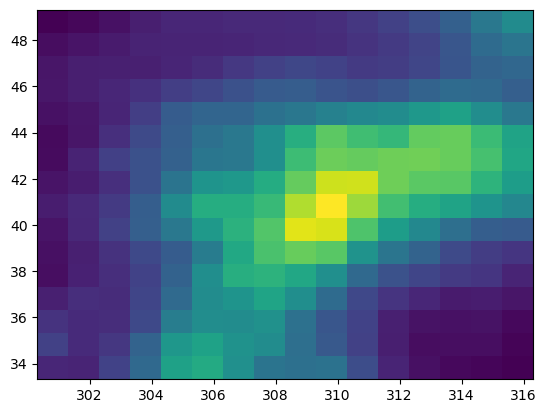

In [51]:
fig, ax = plt.subplots()
ax.pcolormesh(ra_grid, dec_grid, extinctions)
plt.show()

Nearest-neighbor interpolation

In [58]:
xarr, yarr, zarr = line_of_sight(CygOB2_ra, CygOB2_dec, CygOB2_dist)
dist_arr = np.hypot(xarr-sun_pos[0], yarr-sun_pos[1], zarr-sun_pos[2])*gridstep_pc
diff_ext = data[xarr.astype(int), yarr.astype(int), zarr.astype(int)]

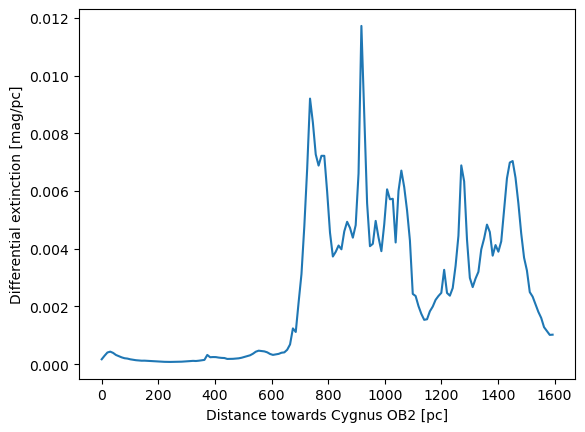

In [59]:
fig, ax = plt.subplots()
ax.plot(dist_arr, diff_ext)
ax.set_xlabel('Distance towards Cygnus OB2 [pc]')
ax.set_ylabel('Differential extinction [mag/pc]')
plt.show()

In [71]:
image_width = 10 # degrees
dx = 0.1 # deg
ra_arr = np.arange(CygOB2_ra - image_width/2, CygOB2_ra + image_width/2 + dx, dx)
dec_arr = np.arange(CygOB2_dec - image_width/2, CygOB2_dec + image_width/2 + dx, dx)
ra_grid, dec_grid = np.meshgrid(ra_arr, dec_arr)
print(ra_grid.shape)

(102, 102)


In [72]:
ds = dist_arr[1] - dist_arr[0]

extinctions = []
for ra, dec in zip(ra_grid.flatten(), dec_grid.flatten()):
    xarr, yarr, zarr = line_of_sight(ra, dec, CygOB2_dist)
    diff_ext = data[xarr.astype(int), yarr.astype(int), zarr.astype(int)]
    extinctions.append(sum(diff_ext * ds))
    
extinctions = np.reshape(np.array(extinctions), ra_grid.shape)

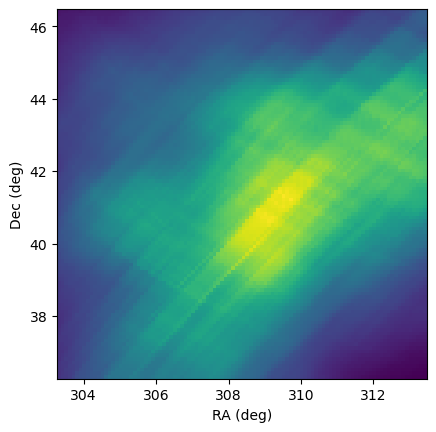

In [76]:
fig, ax = plt.subplots()
ax.pcolormesh(ra_grid, dec_grid, extinctions)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_aspect('equal')
plt.show()

TODO: save as fits image